# Modelo de Clustering con k-means y regresion logistica para clasificacion

Este notebook implementa un proceso de clusterig con k-means, utilizando 4 facies de las cuales son agrupadas dependiendo de la secuencia de analisis en facies binaria arena-arcilla. Los cluster o facies identificados por pozo y por secuencia han sido debidamente correlacionados para verificar su validez.

Luego se procede a realizar con la clusterizacion definida una validación cruzada tipo "leave-one-well-out" para evaluar el desempeño de un modelo de regresión logística entrenado con impedancia acústica P, Impedancia acustica S y relacion de velocidades (Vp/Vs) para clasificar facies (arena/arcilla).

Por ultimo, se genera un modelo de regresion logistica final por secuencia que es utilizado para entrenar una grilla con valores de impedancias y relaciones de velocidades.


## 1. Importar librerías necesarias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
import lasio
import plotly.express as px
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

# Configuración de visualización
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)
pd.set_option('display.max_columns', None)


## 2. Cargar datos

Carga de datos, son tres pozos con informacion para el clustering, de los cuales se modifica el Df para acomodar los datos. Se deja la secuencia de interes en el dataset

In [120]:
# Importar el dataset como csv por pozo del .las origen
Df_well_train = pd.read_csv("V624v2.csv.", sep=";", na_values="-999.25")

# Agrupar por cada metro completo y calcular la mediana, para el caso de la columna [GRAN] se calcula el valor mas frecuentemente repetido
Df_well_train1 = Df_well_train.groupby(Df_well_train['DEPT'].floordiv(1)).median()
Df_well_train2 = Df_well_train.groupby(Df_well_train['DEPT'].floordiv(1)).max()
Df_well_train = Df_well_train1
Df_well_train['GRAN'] = Df_well_train2['GRAN']
Df_well_train.drop(columns=["DEPT"], inplace=True)
Df_well_train

#Orden y limpieza de datos
Df_well_train.dropna(inplace=True)
#Df_well_train.set_index("DEPT", inplace=True)

# Renombrar la columna zona
Df_well_train["zonas"] = (
    Df_well_train["zonas"].astype(str).replace({"0.0": "CBIII", "1.0": "CIV_sup", "2.0": "CIV_medio", "3.0": "CIV_basal"})
)

# Ordenar la columna GRAN, de menor a mayor granulometria, teniendo en cuenta que la gran de conglomerado es de las porosidades menores, queda en segfunda posicion de menor calidad
Df_well_train["GRAN"] = (
    Df_well_train["GRAN"]
    .astype(str)
    .replace({"401": "1", "406": "2", "402": "3", "403": "4", "404": "5", "405": "6"})
)
Df_well_train["GRAN"] = Df_well_train["GRAN"].astype(int)

Df_well_train

AT20   P_IMPEDANCE  S_IMPEDANCE     Vp/Vs      zonas  GRAN
DEPT                                                                  
1726.0  0.194660   7762.669678  3719.087403  2.058750      CBIII     1
1727.0  0.073848   7710.961426  3675.337280  2.090446      CBIII     1
1728.0  0.000000   7026.949463  3375.633423  2.082857      CBIII     1
1729.0  0.000000   7000.112793  3353.282471  2.087232      CBIII     1
1730.0  0.000000   6811.881103  3331.346435  2.050000      CBIII     1
...          ...           ...          ...       ...        ...   ...
2307.0  1.339156  10260.944825  5619.640137  1.825804  CIV_basal     1
2308.0  0.823841  10101.977050  5502.550537  1.822857  CIV_basal     1
2309.0  0.872636   9943.672363  5437.552002  1.830000  CIV_basal     1
2310.0  0.881312  10020.396973  5504.902100  1.825000  CIV_basal     1
2311.0  0.802029  10035.463865  5512.726075  1.826250  CIV_basal     1

[586 rows x 6 columns]

In [121]:
Df_well_test = pd.read_csv("EN667v2.csv", sep=";")
Df_well_test.columns = ["DEPT", "AT20", "P_IMPEDANCE", "S_IMPEDANCE", "Vp/Vs", "zonas", "GRAN"]

# Agrupar por cada metro completo y calcular la mediana, para el caso de la columna [GRAN] se calcula el valor mas frecuentemente repetido
Df_well_test1 = Df_well_test.groupby(Df_well_test['DEPT'].floordiv(1)).median()
Df_well_test2 = Df_well_test.groupby(Df_well_test['DEPT'].floordiv(1)).max()
Df_well_test = Df_well_test1
Df_well_test['GRAN'] = Df_well_test2['GRAN']
Df_well_test.drop(columns=["DEPT"], inplace=True)
Df_well_test

# Renombrar la columna zona
Df_well_test["zonas"] = (
    Df_well_test["zonas"].astype(str).replace({"0.0": "CBIII", "1.0": "CIV_sup", "2.0": "CIV_medio", "3.0": "CIV_basal"})
)

Df_well_test["GRAN"] = (
    Df_well_test["GRAN"]
    .astype(str)
    .replace({"401": "1", "406": "2", "402": "3", "403": "4", "404": "5", "405": "6"})
)
Df_well_test["GRAN"] = Df_well_test["GRAN"].astype(int)


In [122]:
Df_well_testb = pd.read_csv("EN673v2.csv", sep=";")
Df_well_testb.columns = ["DEPT", "AT20", "P_IMPEDANCE", "S_IMPEDANCE", "Vp/Vs", "zonas", "GRAN"]

# Agrupar por cada metro completo y calcular la mediana, para el caso de la columna [GRAN] se calcula el valor mas frecuentemente repetido
Df_well_test1 = Df_well_testb.groupby(Df_well_testb['DEPT'].floordiv(1)).median()
Df_well_test2 = Df_well_testb.groupby(Df_well_testb['DEPT'].floordiv(1)).max()
Df_well_testb = Df_well_test1
Df_well_testb['GRAN'] = Df_well_test2['GRAN']
Df_well_testb.drop(columns=["DEPT"], inplace=True)
Df_well_testb

# Renombrar la columna zona
Df_well_testb["zonas"] = (
    Df_well_testb["zonas"].astype(str).replace({"0.0": "CBIII", "1.0": "CIV_sup", "2.0": "CIV_medio", "3.0": "CIV_basal"})
)

Df_well_testb["GRAN"] = (
    Df_well_testb["GRAN"]
    .astype(str)
    .replace({"401": "1", "406": "2", "402": "3", "403": "4", "404": "5", "405": "6"})
)
Df_well_testb["GRAN"] = Df_well_testb["GRAN"].astype(int)


In [123]:
Df_v624=  Df_well_train.copy()
Df_en667= Df_well_test.copy()
Df_en673= Df_well_testb.copy()

In [124]:
# Filtrar de la columna "zonas" aquellas de interes para el analisis.
Df_v624 = Df_v624[Df_v624["zonas"].isin(["CBIII"])]
Df_en667 = Df_en667[Df_en667["zonas"].isin(["CBIII"])]
Df_en673 = Df_en673[Df_en673["zonas"].isin(["CBIII"])]

In [125]:
Df_v624["well"] = "V624"
Df_en667["well"] = "EN-667"
Df_en673["well"] = "EN-673"

Df=pd.concat([Df_v624,Df_en667,Df_en673],axis=0)
Df

AT20  P_IMPEDANCE  S_IMPEDANCE     Vp/Vs  zonas  GRAN    well
DEPT                                                                     
1726.0  0.194660  7762.669678  3719.087403  2.058750  CBIII     1    V624
1727.0  0.073848  7710.961426  3675.337280  2.090446  CBIII     1    V624
1728.0  0.000000  7026.949463  3375.633423  2.082857  CBIII     1    V624
1729.0  0.000000  7000.112793  3353.282471  2.087232  CBIII     1    V624
1730.0  0.000000  6811.881103  3331.346435  2.050000  CBIII     1    V624
...          ...          ...          ...       ...    ...   ...     ...
2039.0  1.568372  8934.999024  4814.922119  1.857123  CBIII     1  EN-673
2040.0  0.808193  8610.414551  4603.933837  1.876133  CBIII     1  EN-673
2041.0  1.029332  8727.910157  4677.659912  1.853996  CBIII     1  EN-673
2042.0 -0.163338  7484.092529  3686.331421  2.012546  CBIII     1  EN-673
2043.0  0.103804  7689.290772  3808.818359  2.001545  CBIII     1  EN-673

[398 rows x 7 columns]

## 3.Analisis exploratorio

In [126]:
import ydata_profiling as prof

profile = prof.ProfileReport(
    Df, 
    title="Perfilamiento de datos",
    correlations={
        "pearson": {"calculate": True},
        "spearman": {"calculate": True},
        "kendall": {"calculate": True},
        "phi_k": {"calculate": True},
        "cramers": {"calculate": True}
    }
)
profile.to_notebook_iframe()


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Observaciones del Analisis exploratorio

-Las relaciones de velocidades (Vp/Vs) presenta una alta correlacion inversa con la impedancia S. Podria ser util para determinar los valores de Vp/Vs en la grilla con los datos de Imp_S.

-La Imp P y S presentan una relacion directa casi lineal.

-La Vp/Vs y la Imp_S parece tener una buena correlacion con la At20 (-0.46 y 0.65)

-La GRAN no muestra relacion con ninguna variable, los datos no parecen tener una logica que pueda usarse. Se puede sacar del dataset para el analisis.

-Todas las variables parecen tener outliers, haria falta una eliminacion de los ruidos.

## 3.Preparar Df para el clustering

Realizar estandarizado y normalizacion de las variables7
Ejecutar k-means con 4 facies, ordenar clusters y agrupar para dejar un binario

In [127]:
#Eliminar la columna "GRAN"
Df.drop(columns=["GRAN"], inplace=True)

In [128]:
#usar el DBscan para identificar los outliers
from sklearn.cluster import DBSCAN

# Escalar los datos
sc=StandardScaler()
Df_SC=Df.copy()
Df_SC.drop(columns=["zonas"], inplace=True)
Df_SC.drop(columns=["well"], inplace=True)
Df_SC=sc.fit_transform(Df_SC)

# Entrenar el modelo DBSCAN
dbscan=DBSCAN(eps=1.3, min_samples=25)
dbscan.fit(Df_SC)
clusters=dbscan.labels_
Df["clusters"]=clusters

Df


AT20  P_IMPEDANCE  S_IMPEDANCE     Vp/Vs  zonas    well  clusters
DEPT                                                                         
1726.0  0.194660  7762.669678  3719.087403  2.058750  CBIII    V624         0
1727.0  0.073848  7710.961426  3675.337280  2.090446  CBIII    V624         0
1728.0  0.000000  7026.949463  3375.633423  2.082857  CBIII    V624         0
1729.0  0.000000  7000.112793  3353.282471  2.087232  CBIII    V624         0
1730.0  0.000000  6811.881103  3331.346435  2.050000  CBIII    V624         0
...          ...          ...          ...       ...    ...     ...       ...
2039.0  1.568372  8934.999024  4814.922119  1.857123  CBIII  EN-673         0
2040.0  0.808193  8610.414551  4603.933837  1.876133  CBIII  EN-673         0
2041.0  1.029332  8727.910157  4677.659912  1.853996  CBIII  EN-673         0
2042.0 -0.163338  7484.092529  3686.331421  2.012546  CBIII  EN-673         0
2043.0  0.103804  7689.290772  3808.818359  2.001545  CBIII  EN-673         0

[398 rows x 7 columns]

In [129]:
joblib.dump(sc, 'modelo_standardscaler.pkl')
print("Modelo StandardScaler guardado como 'modelo_standardscaler.pkl'")

Modelo StandardScaler guardado como 'modelo_standardscaler.pkl'


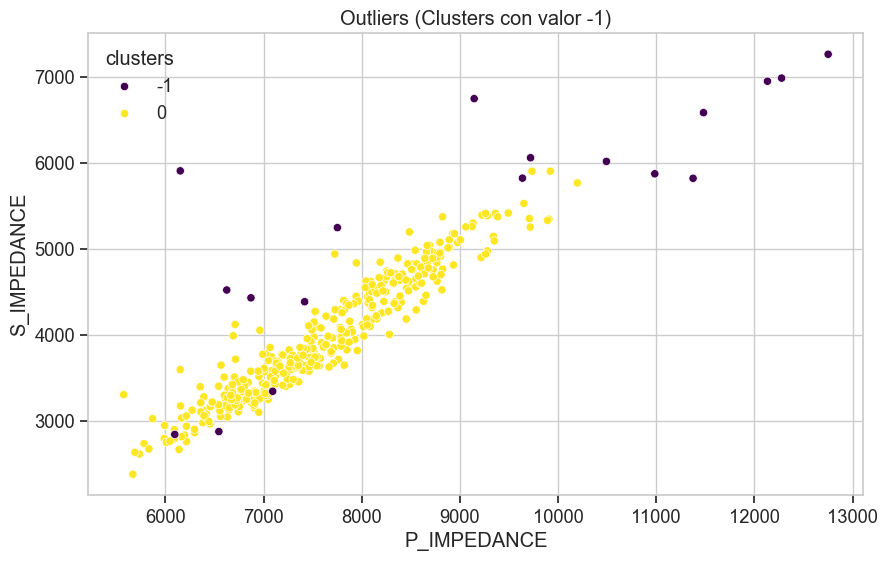

In [130]:
# Visualizar los clusters, mostrar solo los clusters con valor -1}
# Filtrar los datos para mostrar solo los clusters con valor -1
#Df_outliers = Df[Df["clusters"] == -1]

# Visualizar los outliers
plt.figure(figsize=(10, 6))
sns.scatterplot(data=Df, x="P_IMPEDANCE", y="S_IMPEDANCE", hue="clusters", palette="viridis")
plt.title("Outliers (Clusters con valor -1)")
plt.show()

In [131]:
# Eliminar los outliers
Df = Df[Df["clusters"] != -1]
Df.drop(columns=["clusters"], inplace=True)

C:\Users\nahue\AppData\Local\Temp\ipykernel_29312\899757333.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Df.drop(columns=["clusters"], inplace=True)


## 4.Entrenamiento con K-means

In [132]:
# Escalado para K-means
Df_SC = Df.copy()
Df_SC.drop(columns=["zonas"], inplace=True)
Df_SC.drop(columns=["well"], inplace=True)
sc = StandardScaler()
Df_SC = sc.fit_transform(Df_SC)

# Convertir el array escalado a DataFrame con los nombres de columnas correctos
Df_SC = pd.DataFrame(Df_SC, columns=Df.columns.drop(["zonas", "well"]))

Df_SC

AT20  P_IMPEDANCE  S_IMPEDANCE     Vp/Vs
0   -0.580112     0.188312    -0.336865  0.842239
1   -0.625849     0.131957    -0.398333  1.073337
2   -0.653807    -0.613517    -0.819413  1.018003
3   -0.653807    -0.642765    -0.850816  1.049901
4   -0.653807    -0.847910    -0.881636  0.778444
..        ...          ...          ...       ...
375 -0.060044     1.465981     1.202769 -0.627819
376 -0.347837     1.112231     0.906333 -0.489218
377 -0.264117     1.240284     1.009918 -0.650617
378 -0.715645    -0.115297    -0.382887  0.505368
379 -0.614508     0.108339    -0.210794  0.425159

[380 rows x 4 columns]

In [133]:
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
    r2_score,
    silhouette_score,
)
from typing import Optional, Union


def PlotClusterOptimo(
    df: pd.DataFrame, show: Optional[bool] = True, n_cluster_max: Optional[int] = 10, path: Optional[str] = None
):
    """Función que grafica dos subplots: uno con la suma de la distancia entre
     los centroides y los elementos del cluster; otro con el coeficiente de
    silhouette. Se usan para elegir el número optimo de clusteres con el que se
    deben agrupar los datos.

    Args:
        df (pd.DataFrame): Dataframe con datos a clusterizar, solo admite datos
        numéricos, el index puede ser string.
        show (Optional[bool], optional): True o False para mostrar el gráfico. Defaults to True.
        n_cluster_max (int, optional): N° de cluster máximo a investigar. Defaults to 10.
        path (_type_, optional): Ruta donde se quiere guardar el gráfico. Defaults to None.
    """
    sse = {}
    for k in range(1, n_cluster_max):
        kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df)
        # Inertia: Sum of distances of samples to their closest cluster center
        sse[k] = kmeans.inertia_

    silhouette = {}
    for n_cluster in range(2, n_cluster_max):
        kmeans = KMeans(n_clusters=n_cluster, random_state=16).fit(df)
        label = kmeans.labels_
        silhouette[n_cluster] = silhouette_score(df, label, metric="euclidean")

    fig = plt.figure(figsize=(16, 6))
    fig.add_subplot(1, 2, 1)
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.xlabel("Number of cluster", fontsize=14)
    plt.ylabel("SSE", fontsize=14)
    plt.title("Minimizar distancia (SSE)", fontsize=20)
    # plt.grid()

    fig.add_subplot(1, 2, 2)
    plt.plot(list(silhouette.keys()), list(silhouette.values()))
    plt.xlabel("Number of cluster", fontsize=14)
    plt.ylabel("Silhouette Coefficient", fontsize=14)
    plt.title("Silhouette Coefficient", fontsize=20)
    # plt.grid()

    if path is not None:
        try:
            fig.savefig(path + "\\" + f"Plot_N_Clusteres.png")
        except:
            print(
                "No se puede acceder a la ruta especificada para guardar \
los gráficos."
            )

    if show:
        plt.show()
    return

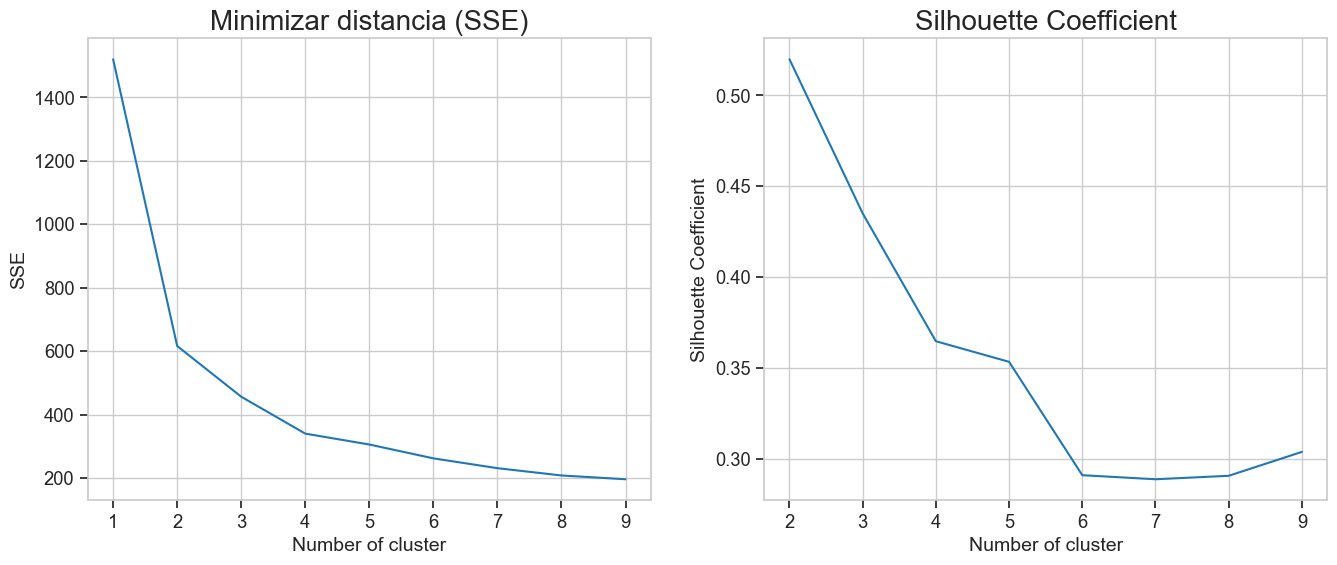

In [134]:
PlotClusterOptimo(Df_SC, show=True, n_cluster_max=10, path=None)

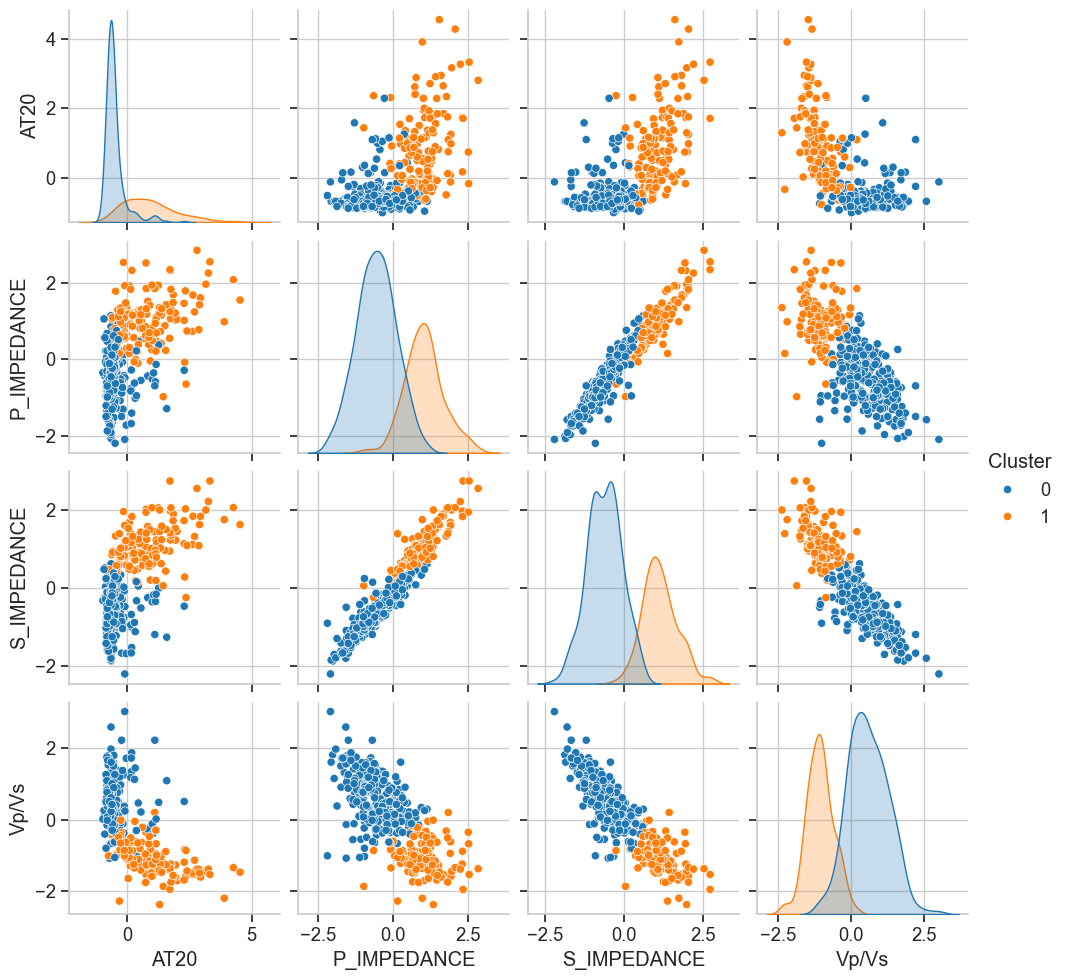

In [135]:
# Parametros
n_clusters_elegido = 4
n_init_elegido = 1000
algoritmo_elegido = "elkan"

# Aplicar el algoritmo
kmeans = KMeans(n_clusters=n_clusters_elegido, random_state=15).fit(
    Df_SC
)
centroids = kmeans.cluster_centers_

# Añadir la columna de clusters al dataframe
Df_SC["Cluster"] = kmeans.labels_

# Ordenar los clusters basados en los valores de impedancia
cluster_order = Df_SC.groupby("Cluster")["Vp/Vs"].mean().sort_values(ascending=False).index
cluster_mapping = {old: new for new, old in enumerate(cluster_order)}
Df_SC["Cluster"] = Df_SC["Cluster"].map(cluster_mapping)

#Para el CIV
#Df_SC.loc[Df_SC["Cluster"].isin([0, 1, 2]), "Cluster"] = 0
#Df_SC.loc[Df_SC["Cluster"] == 3, "Cluster"] = 1

#Para el CBIII
Df_SC.loc[Df_SC["Cluster"].isin([0, 1]), "Cluster"] = 0
Df_SC.loc[Df_SC["Cluster"].isin([2, 3]), "Cluster"] = 1


# Graficar el pairplot con seaborn
sns.pairplot(Df_SC, hue="Cluster", diag_kind="kde", palette="tab10")
plt.show()

In [136]:
# Alinear los índices de Df_SC con Df
Df_SC.index = Df.index

# Incorporar los clusters a los datos originales
Df["Cluster"] = Df_SC["Cluster"]
Df


C:\Users\nahue\AppData\Local\Temp\ipykernel_29312\3609334402.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Df["Cluster"] = Df_SC["Cluster"]


AT20  P_IMPEDANCE  S_IMPEDANCE     Vp/Vs  zonas    well  Cluster
DEPT                                                                        
1726.0  0.194660  7762.669678  3719.087403  2.058750  CBIII    V624        0
1727.0  0.073848  7710.961426  3675.337280  2.090446  CBIII    V624        0
1728.0  0.000000  7026.949463  3375.633423  2.082857  CBIII    V624        0
1729.0  0.000000  7000.112793  3353.282471  2.087232  CBIII    V624        0
1730.0  0.000000  6811.881103  3331.346435  2.050000  CBIII    V624        0
...          ...          ...          ...       ...    ...     ...      ...
2039.0  1.568372  8934.999024  4814.922119  1.857123  CBIII  EN-673        1
2040.0  0.808193  8610.414551  4603.933837  1.876133  CBIII  EN-673        1
2041.0  1.029332  8727.910157  4677.659912  1.853996  CBIII  EN-673        1
2042.0 -0.163338  7484.092529  3686.331421  2.012546  CBIII  EN-673        0
2043.0  0.103804  7689.290772  3808.818359  2.001545  CBIII  EN-673        0

[380 rows x 7 columns]

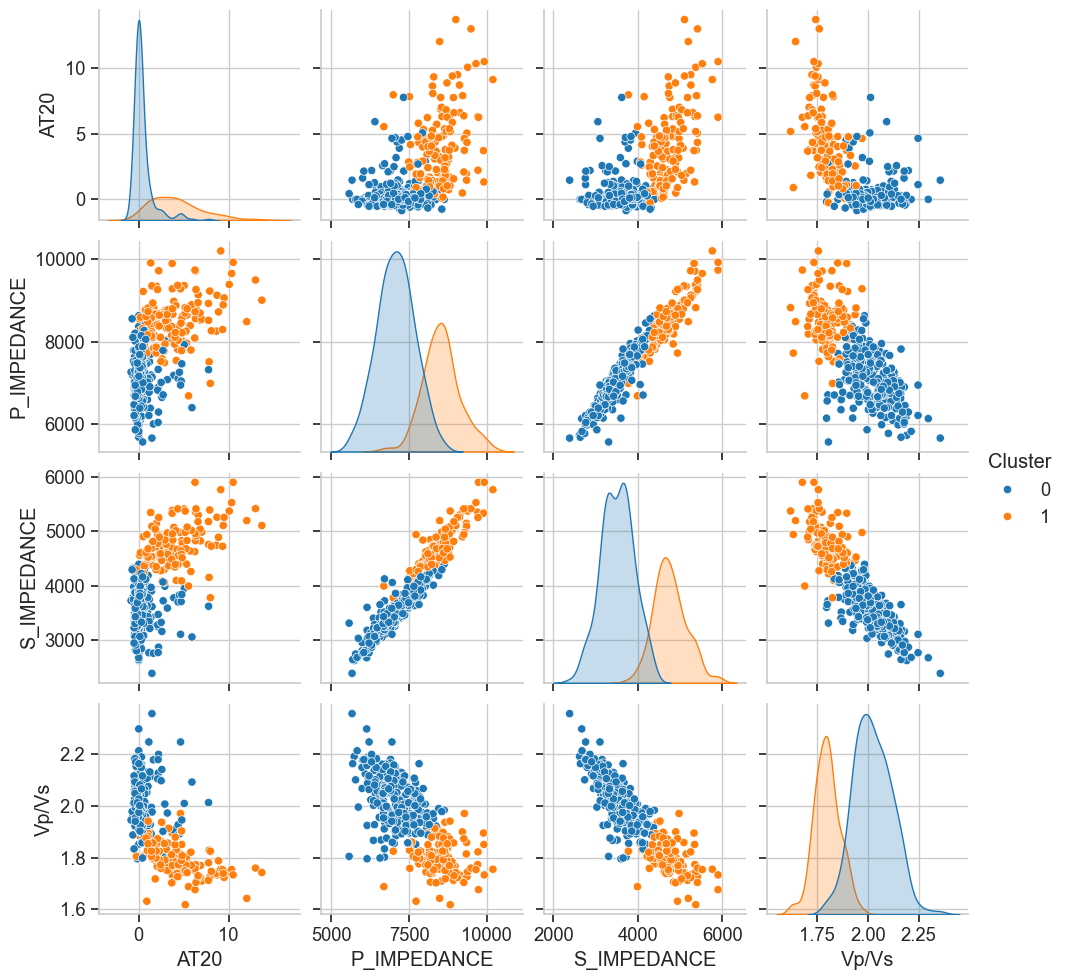

In [137]:
# Graficar el pairplot con seaborn
sns.pairplot(Df, hue="Cluster", diag_kind="kde", palette="tab10")
plt.show()

## 5.Modelo de regresion logistica

En este paso se realizara una validacion cruzada con un modelo de regresion logistica con pozos, leave-one-well-out.

Luego se entrenará el modelo final con todos los pozos y se deja preparado el modelo para ejecutar a la grilla.

In [138]:
# Estadísticas descriptivas por pozo
print("\nEstadísticas descriptivas por pozo:")
Df.groupby(['well', 'Cluster'])['Vp/Vs'].describe()


Estadísticas descriptivas por pozo:


count      mean       std       min       25%       50%  \
well   Cluster                                                            
EN-667 0         80.0  2.002387  0.095459  1.796034  1.950014  1.995788   
       1         48.0  1.788627  0.067391  1.618375  1.744854  1.777403   
EN-673 0         82.0  2.009017  0.087361  1.798931  1.947231  2.000376   
       1         43.0  1.804083  0.054970  1.631881  1.781390  1.805493   
V624   0         83.0  2.058470  0.090305  1.852321  1.996964  2.072500   
       1         44.0  1.800343  0.065770  1.642857  1.762812  1.790625   

                     75%       max  
well   Cluster                      
EN-667 0        2.045194  2.357239  
       1        1.830160  1.937172  
EN-673 0        2.064320  2.247658  
       1        1.825786  1.941514  
V624   0        2.128750  2.298125  
       1        1.851875  1.971071

En este caso, estamos analizando la secuencia basal del CIV muy heterolitica lo que genera un muy bajo N/G. Se puede observar una proporcion de facie arena (1) muy baja que podria influir negativamente en el modelo esa desproporcion.

In [139]:
# Check which cluster has properties typical of sand vs clay
for cluster_val in Df['Cluster'].unique():
    cluster_data = Df[Df['Cluster'] == cluster_val]
    avg_vpvs = cluster_data['Vp/Vs'].mean()
    print(f"Cluster {cluster_val}: Average Vp/Vs = {avg_vpvs:.3f}")
    # Sand typically has lower Vp/Vs than clay
    # So the cluster with lower Vp/Vs is likely sand

Cluster 0: Average Vp/Vs = 2.024
Cluster 1: Average Vp/Vs = 1.797


C:\Users\nahue\AppData\Local\Temp\ipykernel_29312\655993573.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Df['Lithology'] = Df['Cluster'].map(cluster_to_lithology)


<Axes: xlabel='Vp/Vs', ylabel='Count'>

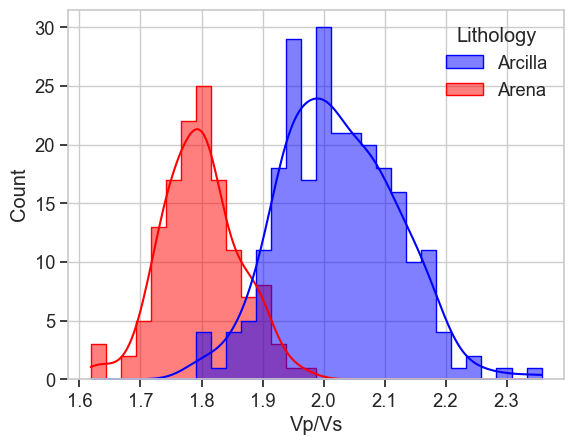

In [140]:
# Define mapping
cluster_to_lithology = {
    0: 'Arcilla',  # Adjust these values as needed
    1: 'Arena'
}

# Use this mapping for plot labels
Df['Lithology'] = Df['Cluster'].map(cluster_to_lithology)

# Then use 'Lithology' instead of 'Cluster' in your plots
sns.histplot(data=Df, x='Vp/Vs', hue='Lithology', 
             kde=True, palette=['blue', 'red'], 
             element='step', bins=30, alpha=0.5)

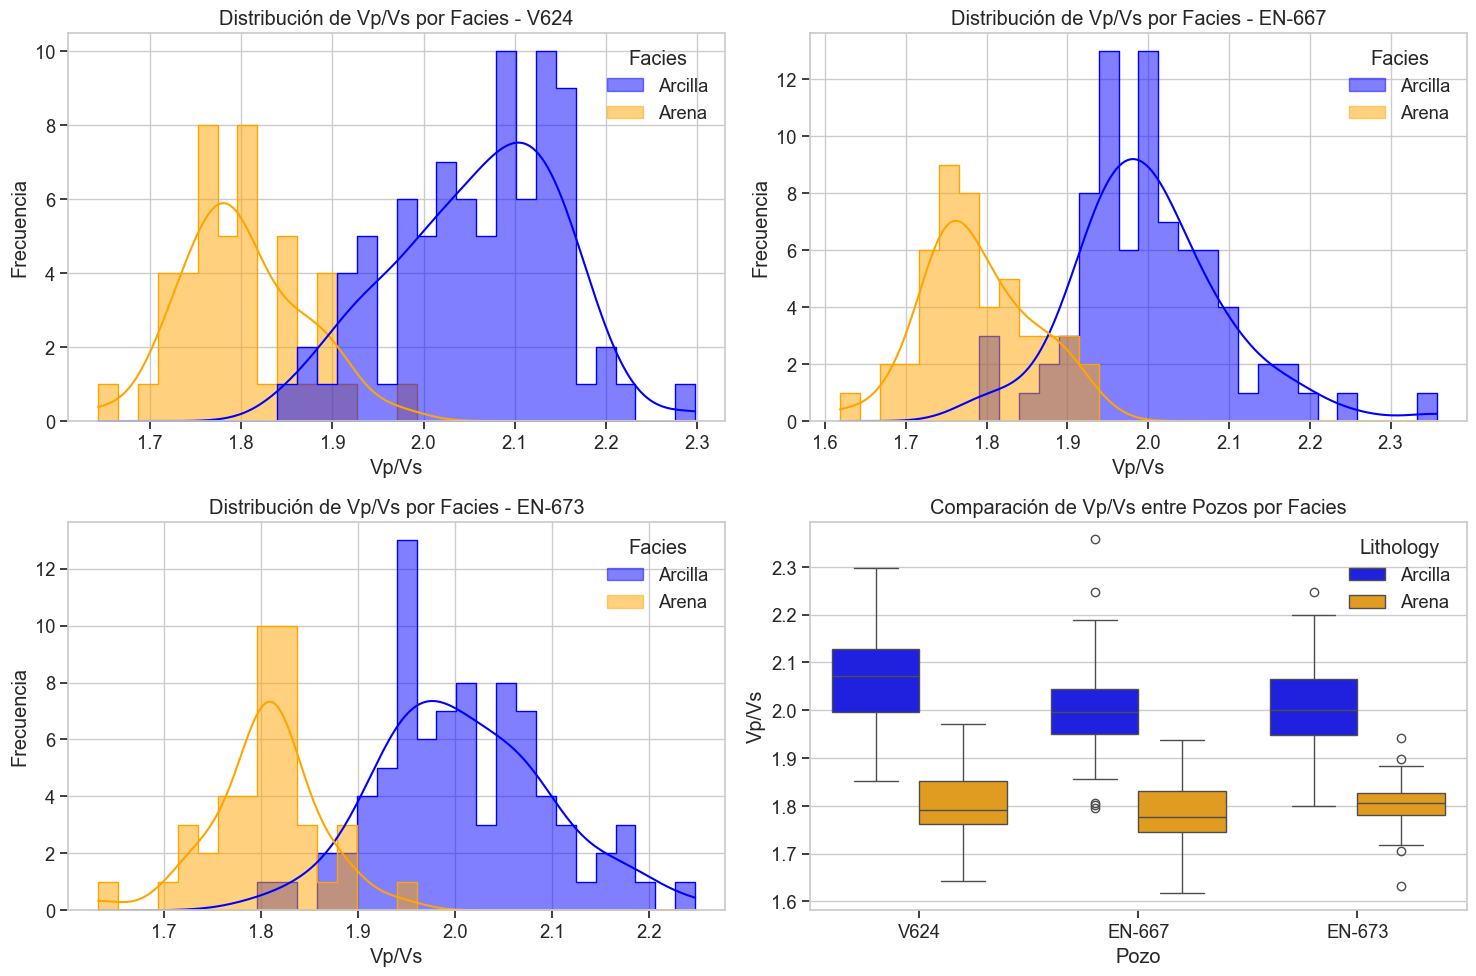

In [141]:
wells = ["V624", "EN-667", "EN-673"]

# Create figure and set a common color palette for consistency
palette = {'Arcilla': 'blue', 'Arena': 'orange'}
plt.figure(figsize=(15, 10))

# Create custom patch objects for the legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='blue', edgecolor='blue', alpha=0.5, label='Arcilla'),
    Patch(facecolor='orange', edgecolor='orange', alpha=0.5, label='Arena')
]

# Create histograms for each well
for i, well in enumerate(wells, 1):
    ax = plt.subplot(2, 2, i)
    data_well = Df[Df['well'] == well]
    
    # Plot histograms
    sns.histplot(data=data_well, x='Vp/Vs', hue='Lithology', 
                 kde=True, palette=palette, 
                 element='step', bins=30, alpha=0.5, ax=ax)
    
    plt.title(f'Distribución de Vp/Vs por Facies - {well}')
    plt.xlabel('Vp/Vs')
    plt.ylabel('Frecuencia')
    
    # Add the custom legend directly to each subplot
    ax.legend(handles=legend_elements, title='Facies')

# Create boxplot
ax = plt.subplot(2, 2, 4)
sns.boxplot(data=Df, x='well', y='Vp/Vs', hue='Lithology', palette=palette, ax=ax)
plt.title('Comparación de Vp/Vs entre Pozos por Facies')
plt.ylabel('Vp/Vs')
plt.xlabel('Pozo')

plt.tight_layout()
plt.show()

Estos graficos son muy utiles para observar la distribucion de los datos y que problemas podemos encontrarnos a la hora de correr el modelo. 

A simple vista, se puede identificar que tomando la variable que mas diferenciada estan las facies como la Vp/Vs hay muy poca superposicion, el modelo deberia funcionar correctamente en esta secuencia.

### Implementacion de validacion cruzada leave-one-well-out

In [142]:
Df_SC["well"]=Df["well"]
Df_SC


AT20  P_IMPEDANCE  S_IMPEDANCE     Vp/Vs  Cluster    well
DEPT                                                                 
1726.0 -0.580112     0.188312    -0.336865  0.842239        0    V624
1727.0 -0.625849     0.131957    -0.398333  1.073337        0    V624
1728.0 -0.653807    -0.613517    -0.819413  1.018003        0    V624
1729.0 -0.653807    -0.642765    -0.850816  1.049901        0    V624
1730.0 -0.653807    -0.847910    -0.881636  0.778444        0    V624
...          ...          ...          ...       ...      ...     ...
2039.0 -0.060044     1.465981     1.202769 -0.627819        1  EN-673
2040.0 -0.347837     1.112231     0.906333 -0.489218        1  EN-673
2041.0 -0.264117     1.240284     1.009918 -0.650617        1  EN-673
2042.0 -0.715645    -0.115297    -0.382887  0.505368        0  EN-673
2043.0 -0.614508     0.108339    -0.210794  0.425159        0  EN-673

[380 rows x 6 columns]

In [143]:
def evaluate_model(y_true, y_pred, y_proba=None):
    """Evaluar el rendimiento del modelo con múltiples métricas"""
    # Accuracy
    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {acc:.4f}")
    
    # Reporte de clasificación
    print("\nReporte de clasificación:")
    print(classification_report(y_true, y_pred, target_names=['Arcilla', 'Arena']))
    
    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Arcilla', 'Arena'],
                yticklabels=['Arcilla', 'Arena'])
    plt.xlabel('Predicción')
    plt.ylabel('Valor Real')
    plt.title('Matriz de Confusión')
    plt.tight_layout()
    plt.show()
    
    # ROC Curve (si se proporcionan probabilidades)
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_true, y_proba)
        roc_auc = auc(fpr, tpr)
        
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2,
                 label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Tasa de Falsos Positivos')
        plt.ylabel('Tasa de Verdaderos Positivos')
        plt.title('Curva ROC')
        plt.legend(loc="lower right")
        plt.show()
    
    return acc


=== Validación con V624 como prueba ===
Entrenando con: EN-667, EN-673
Evaluando en: V624

Coeficientes del modelo:
Intercepto: [-2.71352098]
Coeficiente para P_IMPEDANCE: 1.4925
Coeficiente para S_IMPEDANCE: 2.1016
Coeficiente para Vp/Vs: -3.1989

Resultados para el conjunto de prueba:
Accuracy: 0.9764

Reporte de clasificación:
              precision    recall  f1-score   support

     Arcilla       0.99      0.98      0.98        83
       Arena       0.96      0.98      0.97        44

    accuracy                           0.98       127
   macro avg       0.97      0.98      0.97       127
weighted avg       0.98      0.98      0.98       127



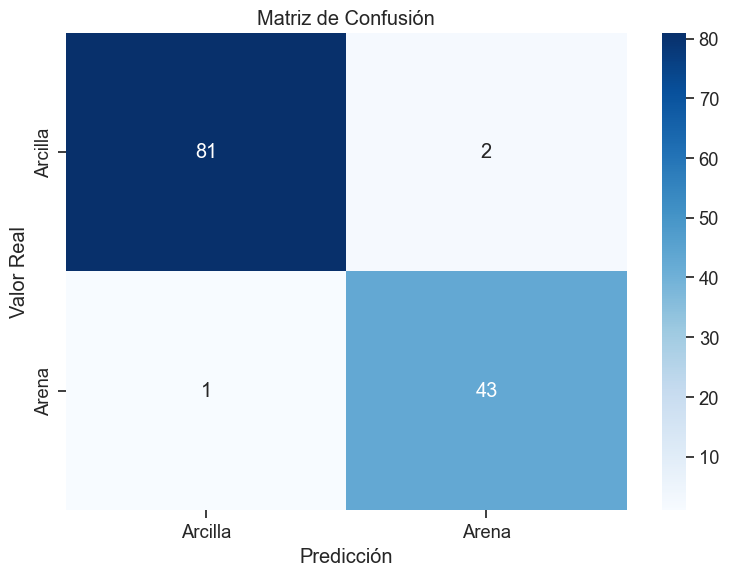

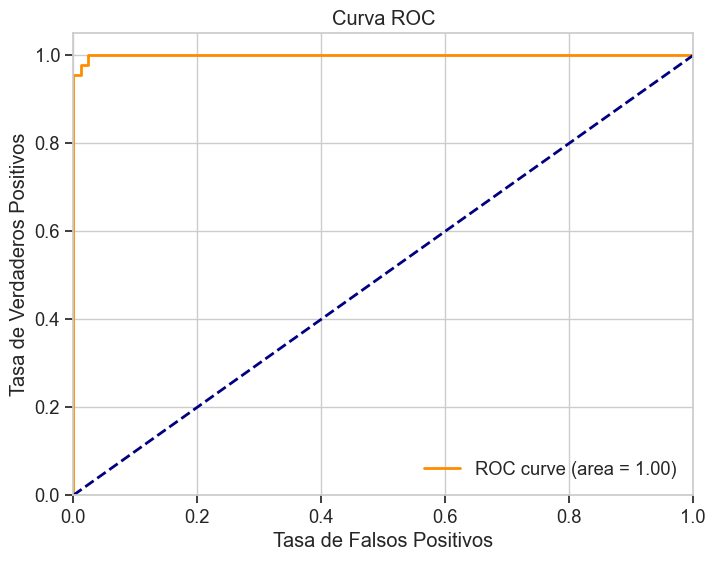


=== Validación con EN-667 como prueba ===
Entrenando con: V624, EN-673
Evaluando en: EN-667

Coeficientes del modelo:
Intercepto: [-2.54457665]
Coeficiente para P_IMPEDANCE: 1.3973
Coeficiente para S_IMPEDANCE: 1.9657
Coeficiente para Vp/Vs: -3.0879

Resultados para el conjunto de prueba:
Accuracy: 0.9844

Reporte de clasificación:
              precision    recall  f1-score   support

     Arcilla       0.98      1.00      0.99        80
       Arena       1.00      0.96      0.98        48

    accuracy                           0.98       128
   macro avg       0.99      0.98      0.98       128
weighted avg       0.98      0.98      0.98       128



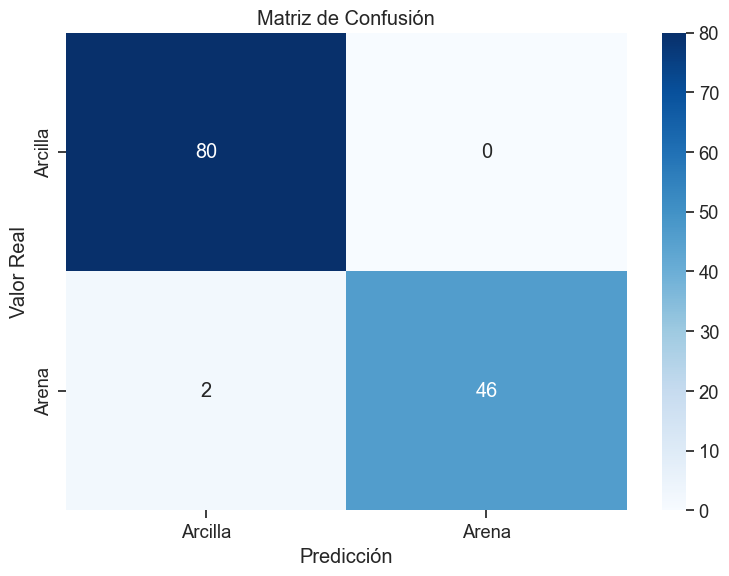

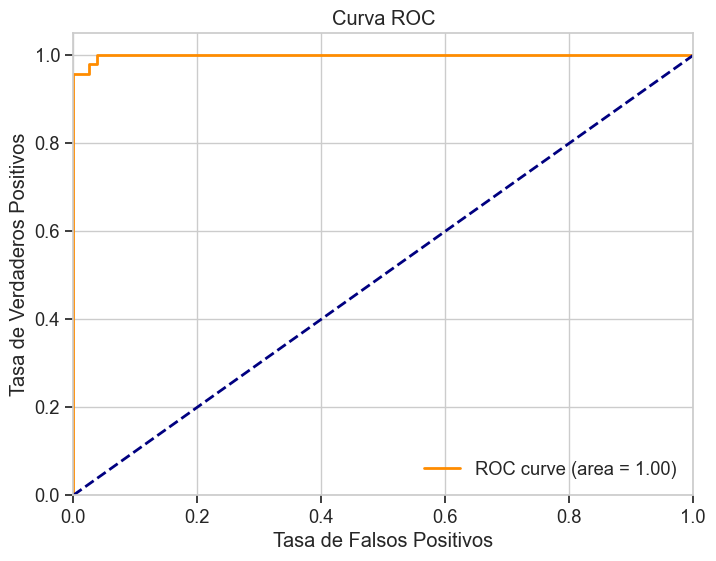


=== Validación con EN-673 como prueba ===
Entrenando con: V624, EN-667
Evaluando en: EN-673

Coeficientes del modelo:
Intercepto: [-2.45968313]
Coeficiente para P_IMPEDANCE: 1.2121
Coeficiente para S_IMPEDANCE: 2.1852
Coeficiente para Vp/Vs: -2.8889

Resultados para el conjunto de prueba:
Accuracy: 0.9840

Reporte de clasificación:
              precision    recall  f1-score   support

     Arcilla       0.99      0.99      0.99        82
       Arena       0.98      0.98      0.98        43

    accuracy                           0.98       125
   macro avg       0.98      0.98      0.98       125
weighted avg       0.98      0.98      0.98       125



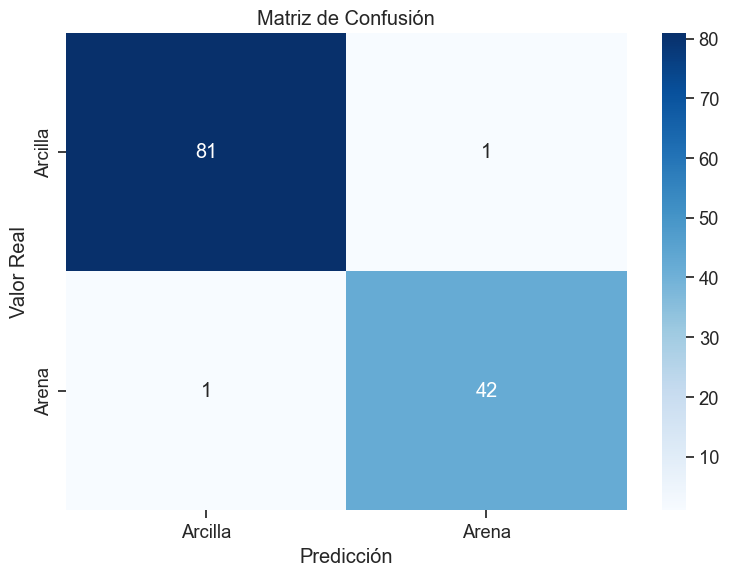

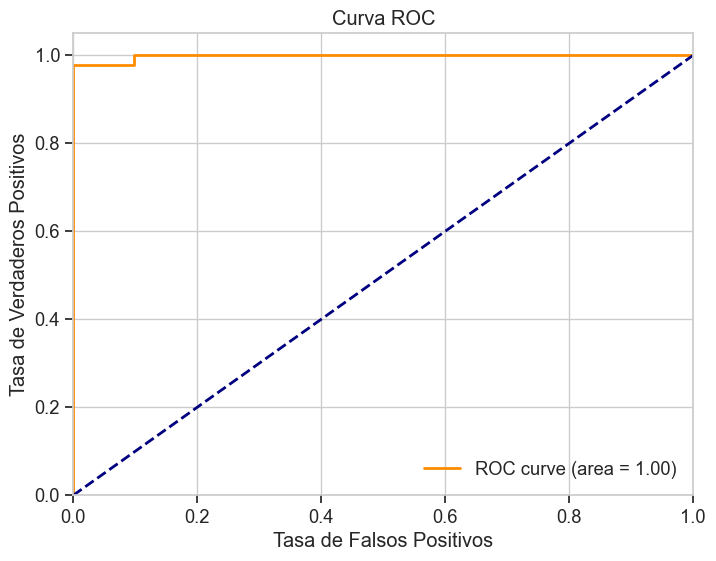

In [144]:
# Almacenar resultados de la validación cruzada
results = []

# Para cada pozo como conjunto de prueba
for test_well in wells:
    print(f"\n=== Validación con {test_well} como prueba ===")
    
    # Dividir en entrenamiento y prueba
    X_train = Df_SC[Df_SC['well'] != test_well][['P_IMPEDANCE', 'S_IMPEDANCE', 'Vp/Vs']].values
    
    y_train = Df_SC[Df_SC['well'] != test_well]['Cluster'].values.ravel()
    
    X_test = Df_SC[Df_SC['well'] == test_well][['P_IMPEDANCE', 'S_IMPEDANCE', 'Vp/Vs']].values
    
    y_test = Df_SC[Df_SC['well'] == test_well]['Cluster'].values.ravel()
    
    # Identificar pozos de entrenamiento
    train_wells = [w for w in wells if w != test_well]
    print(f"Entrenando con: {', '.join(train_wells)}")
    print(f"Evaluando en: {test_well}")
    
    # Entrenar el modelo
    model = LogisticRegression(random_state=16, max_iter=1000)
    model.fit(X_train, y_train)
    
    # Coeficientes del modelo
    print(f"\nCoeficientes del modelo:")
    print(f"Intercepto: {model.intercept_}")
    for i, feature_name in enumerate(['P_IMPEDANCE', 'S_IMPEDANCE', 'Vp/Vs']):
        print(f"Coeficiente para {feature_name}: {model.coef_[0][i]:.4f}")
    
    # Realizar predicciones
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)  # Probabilidades para la clase Arena
    
    # Evaluar modelo
    print("\nResultados para el conjunto de prueba:")
    acc = evaluate_model(y_test, y_pred, y_proba[:, 1])
    
    # Guardar resultados
    results.append({
        'test_well': test_well,
        'train_wells': train_wells,
        'accuracy': acc,
        'intercept': model.intercept_[0],
        'coefficients': {
            'P_IMPEDANCE': model.coef_[0][0],
            'S_IMPEDANCE': model.coef_[0][1],
            'Vp/Vs': model.coef_[0][2]
        }
    })

### Visualizar punto de corte optimo para la prediccion, por default es 0.5

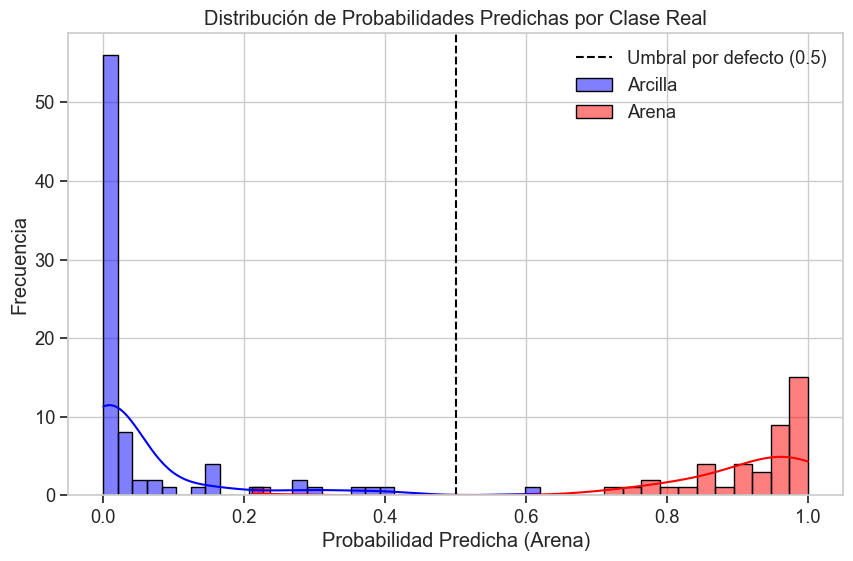

In [145]:
# Para el último modelo entrenado (como ejemplo)
plt.figure(figsize=(10, 6))

# Histograma de probabilidades predichas por clase real
sns.histplot(x=y_proba[y_test == 0, 1], bins=30, alpha=0.5, color='blue', kde=True, label='Arcilla')
sns.histplot(x=y_proba[y_test == 1, 1], bins=30, alpha=0.5, color='red', kde=True, label='Arena')

plt.axvline(x=0.5, color='black', linestyle='--', 
            label='Umbral por defecto (0.5)')
plt.title('Distribución de Probabilidades Predichas por Clase Real')
plt.xlabel('Probabilidad Predicha (Arena)')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

Con este grafico podemos identificar el umbral mas optimo para clasificar arena.
Se observa que los umbrales estan bien separados, se puede observar una clasificacion de arcilla en 0.6 pero no se repite, puede ser un caso outlier. Se toma el valor de 0.5

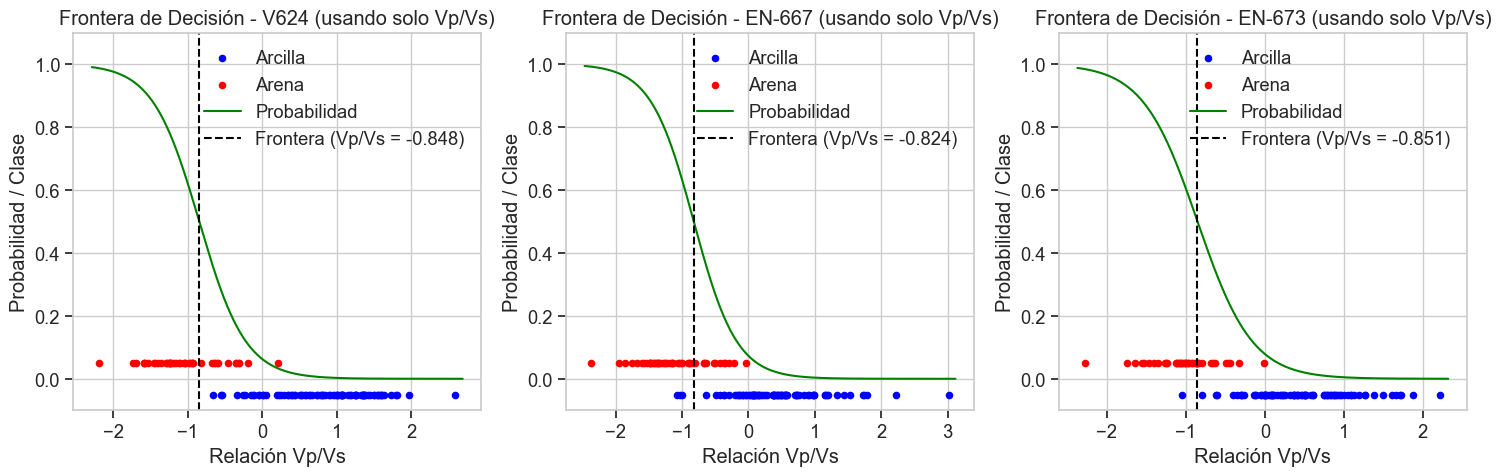

In [146]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(15, 5))
for i, result in enumerate(results):
    plt.subplot(1, 3, i+1)
    test_well = result['test_well']
    
    # Obtener datos del pozo de prueba
    data_well = Df_SC[Df_SC['well'] == test_well]
    
    # Usar SOLO Vp/Vs como variable
    X_vpvs = data_well['Vp/Vs'].values
    y = data_well['Cluster'].values
    
    # Crear un rango de valores para Vp/Vs
    vpvs_min, vpvs_max = X_vpvs.min()-0.1, X_vpvs.max()+0.1
    vpvs_range = np.linspace(vpvs_min, vpvs_max, 1000)
    
    # Comprobar si tenemos coeficiente para Vp/Vs
    if 'Vp/Vs' in result['coefficients']:
        # Obtener coeficientes relevantes del modelo
        intercept = result['intercept']
        coef_vpvs = result['coefficients']['Vp/Vs']
        
        # Calcular probabilidades usando solo Vp/Vs
        z = intercept + coef_vpvs * vpvs_range
        proba = 1 / (1 + np.exp(-z))
        
        # Frontera de decisión solo con Vp/Vs
        decision_boundary = -intercept / coef_vpvs
        
        title_suffix = "usando solo Vp/Vs"
    else:
        # No tenemos coeficiente para Vp/Vs - mostrar mensaje de error
        proba = np.ones_like(vpvs_range) * 0.5
        decision_boundary = None
        title_suffix = "(ERROR: No hay coeficiente para Vp/Vs)"
    
    # Visualizar los datos y la frontera de decisión
    plt.scatter(X_vpvs[y==0], np.zeros_like(X_vpvs[y==0]) - 0.05, c='blue', s=20, label='Arcilla')
    plt.scatter(X_vpvs[y==1], np.zeros_like(X_vpvs[y==1]) + 0.05, c='red', s=20, label='Arena')
    plt.plot(vpvs_range, proba, 'g-', label='Probabilidad')
    
    # Solo dibujamos la frontera si está dentro del rango visible y existe
    if decision_boundary is not None and vpvs_min <= decision_boundary <= vpvs_max:
        plt.axvline(x=decision_boundary, color='black', linestyle='--', 
                    label=f'Frontera (Vp/Vs = {decision_boundary:.3f})')
    
    plt.title(f'Frontera de Decisión - {test_well} ({title_suffix})')
    plt.xlabel('Relación Vp/Vs')
    plt.ylabel('Probabilidad / Clase')
    plt.ylim(-0.1, 1.1)
    plt.legend(loc='best')

plt.tight_layout()
plt.savefig('fronteras_decision_solo_vpvs.png')
plt.show()

Tener en cuenta  que estos son valores escalados, para que sea util este grafico se debe aplicar sobre el dataset con el escalado invertido.


=== Entrenamiento del Modelo Final con Múltiples Variables ===
Parámetros del modelo:
Intercepto: -2.8725
Coeficiente para AI_P: 1.5069
Coeficiente para Vp/Vs: -3.5018
Coeficiente para AI_S: 2.2720

Importancia relativa de las variables:
AI_P: 20.70%
Vp/Vs: 48.10%
AI_S: 31.21%

Evaluación del modelo:
Accuracy: 0.9816

Reporte de clasificación:
              precision    recall  f1-score   support

     Arcilla       0.98      0.99      0.99       245
       Arena       0.98      0.97      0.97       135

    accuracy                           0.98       380
   macro avg       0.98      0.98      0.98       380
weighted avg       0.98      0.98      0.98       380



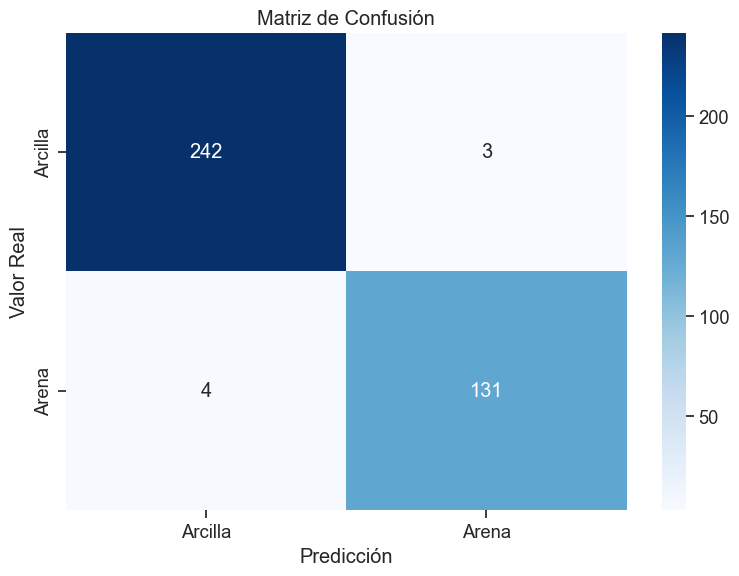

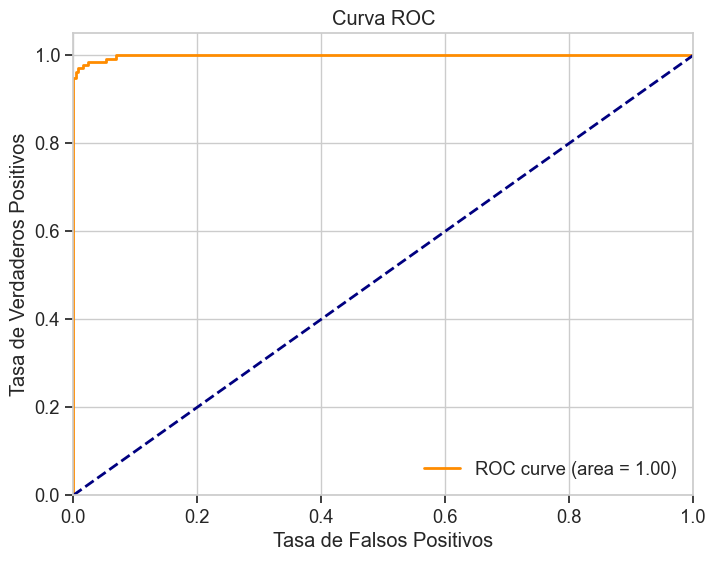

0.9815789473684211

In [147]:
print("\n=== Entrenamiento del Modelo Final con Múltiples Variables ===")
# Seleccionar todas las características relevantes
X_all = Df_SC[['P_IMPEDANCE', 'Vp/Vs', 'S_IMPEDANCE']].values
y_all = Df_SC['Cluster'].values

# Entrenar el modelo con todas las características (ya escaladas)
final_model = LogisticRegression(random_state=42, max_iter=1000)
final_model.fit(X_all, y_all)

# Mostrar los coeficientes
print("Parámetros del modelo:")
print(f"Intercepto: {final_model.intercept_[0]:.4f}")
print(f"Coeficiente para AI_P: {final_model.coef_[0][0]:.4f}")
print(f"Coeficiente para Vp/Vs: {final_model.coef_[0][1]:.4f}")
print(f"Coeficiente para AI_S: {final_model.coef_[0][2]:.4f}")

# Calcular la importancia relativa de las variables
coef_abs = np.abs(final_model.coef_[0])
importance = coef_abs / np.sum(coef_abs) * 100
print("\nImportancia relativa de las variables:")
print(f"AI_P: {importance[0]:.2f}%")
print(f"Vp/Vs: {importance[1]:.2f}%")
print(f"AI_S: {importance[2]:.2f}%")

# Evaluar el modelo
print("\nEvaluación del modelo:")
y_pred = final_model.predict(X_all)
y_proba = final_model.predict_proba(X_all)[:, 1]
proba_arena = y_proba
pred_arena_mod = (proba_arena > 0.5).astype(int)
evaluate_model(y_all, y_pred, y_proba)

## 6-Funcion para aplicar el modelo a la grilla

In [113]:
def predict_facies_grid(grid, model):
    """
    Aplicar el modelo de regresión logística a datos de grilla
    
    Parámetros:
    -----------
    grid : array-like
        Array con valores de impedancias y Vp/Vs en la grilla
    model : objeto LogisticRegression de scikit-learn
        Modelo entrenado
        
    Retorna:
    --------
    facies_pred : array-like
        Predicciones de facies (0=arcilla, 1=arena)
    proba_pred : array-like
        Probabilidades de pertenecer a la clase arena
    """
    # Asegurar formato correcto
    if grid.ndim == 1:
        grid = grid.reshape(-1, 1)
    
    # Predecir facies
    facies_pred = model.predict(grid)
    
    # Predecir probabilidades
    proba_pred = model.predict_proba(grid)[:, 1]
    proba_arena = proba_pred
    pred_arena_mod = (proba_arena > 0.5).astype(int)
    
    
    return facies_pred, proba_pred

In [82]:
# Ejemplo de aplicación a datos de grilla (usando X_test como ejemplo)
print("\nAplicando modelo a datos de ejemplo...")
facies_grid, proba_grid = predict_facies_grid(X_test, final_model)

# Mostrar resultados de ejemplo
print(f"Facies predecidas (primeros 10): {facies_grid[:10]}")  # Adjusted to show the first 10 predictions
print(f"Probabilidades (primeros 10): {proba_grid[:10].round(2)}")  # Adjusted to show the first 10 probabilities


Aplicando modelo a datos de ejemplo...
Facies predecidas (primeros 10): [0 0 0 0 0 0 0 1 1 0]
Probabilidades (primeros 10): [0.   0.   0.   0.   0.   0.   0.08 0.94 1.   0.  ]


In [29]:
# Guardar el modelo
joblib.dump(final_model, 'modelo_regresion_logistica_facies_CBIII.pkl')
print("\nModelo guardado como 'modelo_regresion_logistica_facies_CBIII.pkl'")


Modelo guardado como 'modelo_regresion_logistica_facies_CBIII.pkl'


In [ ]:
# Ejemplo de cómo cargar y usar el modelo guardado
# modelo_cargado = joblib.load('modelo_regresion_logistica_facies.pkl')
# nuevos_datos = ... # Cargar nuevos datos de impedancia acústica P
# facies_pred, proba_pred = predict_facies_grid(nuevos_datos, modelo_cargado)

In [148]:
Df_grid= pd.read_csv("grilla_con_vp_vs_predicho.csv", sep=",")
Df_grid

x          y        z  S_IMPEDANCE      zones      ImpP  \
0        2589675.0  4938225.0 -1155.80      4215.14      CBIII   7888.12   
1        2589725.0  4938225.0 -1154.36      4212.65      CBIII   7898.13   
2        2589775.0  4938225.0 -1153.08      3927.97      CBIII   7504.63   
3        2589825.0  4938225.0 -1152.10      3911.87      CBIII   7488.02   
4        2589875.0  4938225.0 -1150.94      3832.98      CBIII   7388.17   
...            ...        ...      ...          ...        ...       ...   
4350974  2588825.0  4941925.0 -1529.28      5783.77  CIV_basal  10225.01   
4350975  2588825.0  4941925.0 -1529.65      5783.77  CIV_basal  10225.01   
4350976  2588825.0  4941925.0 -1530.02      5783.77  CIV_basal  10225.01   
4350977  2588825.0  4941925.0 -1530.39      5783.77  CIV_basal  10225.01   
4350978  2588825.0  4941925.0 -1530.76      5783.77  CIV_basal  10225.01   

         VP_VS_PREDICTED  
0               1.888375  
1               1.888715  
2               1.930943  
3               1.933539  
4               1.946584  
...                  ...  
4350974         1.767935  
4350975         1.767935  
4350976         1.767935  
4350977         1.767935  
4350978         1.767935  

[4350979 rows x 7 columns]

In [149]:

# Ensure the column names match exactly
Df_grid = Df_grid[Df_grid["zones"].isin(["CBIII"])]

#renombrar columna ImpP y VP_VS_PREDICTED
Df_grid.rename(columns={"ImpP": "P_IMPEDANCE", "VP_VS_PREDICTED": "Vp/Vs"}, inplace=True)

#eliminar columna "zones"
Df_grid.drop(columns=["zones"], inplace=True)

Df_grid

C:\Users\nahue\AppData\Local\Temp\ipykernel_29312\353857617.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Df_grid.rename(columns={"ImpP": "P_IMPEDANCE", "VP_VS_PREDICTED": "Vp/Vs"}, inplace=True)
C:\Users\nahue\AppData\Local\Temp\ipykernel_29312\353857617.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Df_grid.drop(columns=["zones"], inplace=True)


x          y        z  S_IMPEDANCE  P_IMPEDANCE     Vp/Vs
0       2589675.0  4938225.0 -1155.80      4215.14      7888.12  1.888375
1       2589725.0  4938225.0 -1154.36      4212.65      7898.13  1.888715
2       2589775.0  4938225.0 -1153.08      3927.97      7504.63  1.930943
3       2589825.0  4938225.0 -1152.10      3911.87      7488.02  1.933539
4       2589875.0  4938225.0 -1150.94      3832.98      7388.17  1.946584
...           ...        ...      ...          ...          ...       ...
919697  2587875.0  4941725.0 -1129.39      3602.79      7091.40  1.987808
919698  2585475.0  4941825.0 -1129.01      3853.31      7432.20  1.943170
919699  2585425.0  4941875.0 -1127.91      3762.32      7321.99  1.958734
919700  2586775.0  4940025.0 -1211.51      3984.22      7607.20  1.922052
919701  2586675.0  4940075.0 -1210.37      4224.24      7926.61  1.887140

[919702 rows x 6 columns]

In [150]:
# Cargar el modelo de StandardScaler
sc = joblib.load('modelo_standardscaler.pkl')
print("Modelo StandardScaler cargado correctamente.")

Modelo StandardScaler cargado correctamente.


In [151]:
sc.feature_names_in_

array(['AT20', 'P_IMPEDANCE', 'S_IMPEDANCE', 'Vp/Vs'], dtype=object)

In [155]:
# Select specific columns and create a copy
Df_grid_SC = Df_grid[["P_IMPEDANCE", "S_IMPEDANCE", "Vp/Vs"]].copy()
Df_grid_SC["AT20"]=1

# Reorder columns to have AT20 first
Df_grid_SC = Df_grid_SC[["AT20", "P_IMPEDANCE", "S_IMPEDANCE", "Vp/Vs"]]

Df_grid_SC=sc.transform(Df_grid_SC)

Df_grid_SC = pd.DataFrame(Df_grid_SC, columns=["AT20", "P_IMPEDANCE", "S_IMPEDANCE", "Vp/Vs"])
Df_grid_SC

AT20  P_IMPEDANCE  S_IMPEDANCE     Vp/Vs
0      -0.304114     0.213301     0.233777 -0.296249
1      -0.304114     0.222663     0.230712 -0.294036
2      -0.304114    -0.145379    -0.119781 -0.018636
3      -0.304114    -0.160914    -0.139603 -0.001709
4      -0.304114    -0.254304    -0.236731  0.083368
...          ...          ...          ...       ...
919697 -0.304114    -0.531874    -0.520137  0.352217
919698 -0.304114    -0.213123    -0.211701  0.061103
919699 -0.304114    -0.316202    -0.323727  0.162604
919700 -0.304114    -0.049445    -0.050527 -0.076625
919701 -0.304114     0.249301     0.244981 -0.304306

[919702 rows x 4 columns]

In [157]:
Df_grid_SC.drop(columns=["AT20"], inplace=True)

In [158]:
facies_pred=final_model.predict(Df_grid_SC)
Df_grid_SC["Facies"]=facies_pred
Df_grid_SC

C:\Users\nahue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


P_IMPEDANCE  S_IMPEDANCE     Vp/Vs  Facies
0          0.213301     0.233777 -0.296249       0
1          0.222663     0.230712 -0.294036       0
2         -0.145379    -0.119781 -0.018636       0
3         -0.160914    -0.139603 -0.001709       0
4         -0.254304    -0.236731  0.083368       0
...             ...          ...       ...     ...
919697    -0.531874    -0.520137  0.352217       0
919698    -0.213123    -0.211701  0.061103       0
919699    -0.316202    -0.323727  0.162604       0
919700    -0.049445    -0.050527 -0.076625       0
919701     0.249301     0.244981 -0.304306       0

[919702 rows x 4 columns]

In [110]:
# Ejemplo de cómo cargar y usar el modelo guardado
#modelo_cargado = joblib.load('modelo_regresion_logistica_facies_CBIII.pkl')
nuevos_datos = Df_grid_SC
facies_pred, proba_pred = predict_facies_grid(nuevos_datos, final_model)

C:\Users\nahue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\nahue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [159]:
Df_grid["Facies"]=facies_pred
Df_grid

C:\Users\nahue\AppData\Local\Temp\ipykernel_29312\3145340037.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Df_grid["Facies"]=facies_pred


x          y        z  S_IMPEDANCE  P_IMPEDANCE     Vp/Vs  \
0       2589675.0  4938225.0 -1155.80      4215.14      7888.12  1.888375   
1       2589725.0  4938225.0 -1154.36      4212.65      7898.13  1.888715   
2       2589775.0  4938225.0 -1153.08      3927.97      7504.63  1.930943   
3       2589825.0  4938225.0 -1152.10      3911.87      7488.02  1.933539   
4       2589875.0  4938225.0 -1150.94      3832.98      7388.17  1.946584   
...           ...        ...      ...          ...          ...       ...   
919697  2587875.0  4941725.0 -1129.39      3602.79      7091.40  1.987808   
919698  2585475.0  4941825.0 -1129.01      3853.31      7432.20  1.943170   
919699  2585425.0  4941875.0 -1127.91      3762.32      7321.99  1.958734   
919700  2586775.0  4940025.0 -1211.51      3984.22      7607.20  1.922052   
919701  2586675.0  4940075.0 -1210.37      4224.24      7926.61  1.887140   

        Facies  
0            0  
1            0  
2            0  
3            0  
4            0  
...        ...  
919697       0  
919698       0  
919699       0  
919700       0  
919701       0  

[919702 rows x 7 columns]

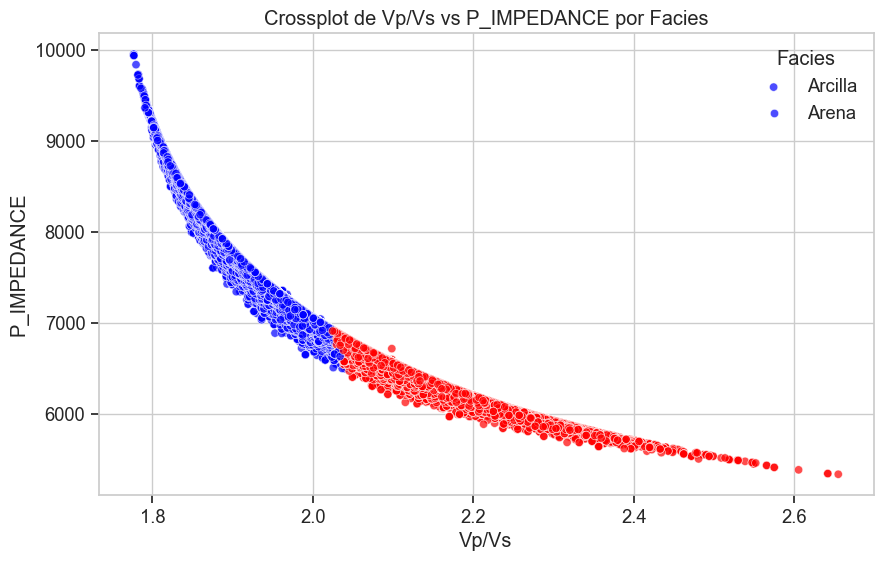

In [160]:
# Graficar un crossplot con Vp/Vs y P_IMPEDANCE coloreado por las facies
plt.figure(figsize=(10, 6))
sns.scatterplot(data=Df_grid, x="Vp/Vs", y="P_IMPEDANCE", hue="Facies", palette=["blue", "red"], alpha=0.7)
plt.title("Crossplot de Vp/Vs vs P_IMPEDANCE por Facies")
plt.xlabel("Vp/Vs")
plt.ylabel("P_IMPEDANCE")
plt.legend(title="Facies", labels=["Arcilla", "Arena"])
plt.grid(True)
plt.show()